In [1]:
import os
import numpy as np
import time
import random
import torch
import matplotlib.pyplot as plt
from tsai.all import get_splits, TSDatasets, TSDataLoaders, TSStandardize,Categorize

In [2]:
from geoxts.benchmark_models import random_seed, build_model, LSTM_2dCNN
from geoxts.grad_cam import gradcam_simdataset,plot_grad_overview, plot_grad_detail, plot_batch, Grad_2dCNN, Grad_RNN

In [3]:
from fastai.learner import *
from fastai.metrics import accuracy

In [4]:

random_seed(0, use_cuda=True)
global wsize
wsize = 100

In [5]:
X,y = gradcam_simdataset(wsize)

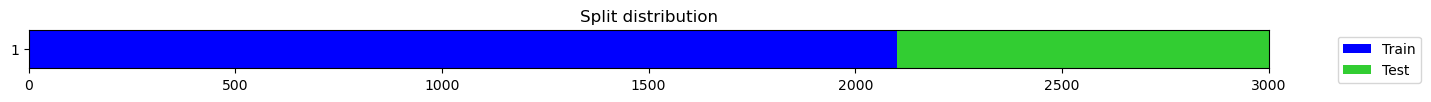

In [6]:
splits = get_splits(y, valid_size=0.3, stratify=True, random_state=21, shuffle=False)
#converting to tesor using inbuit TSDatasets function
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
#tensor dataloader
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=25, batch_tfms=[TSStandardize(by_var=True)], num_workers=0) 

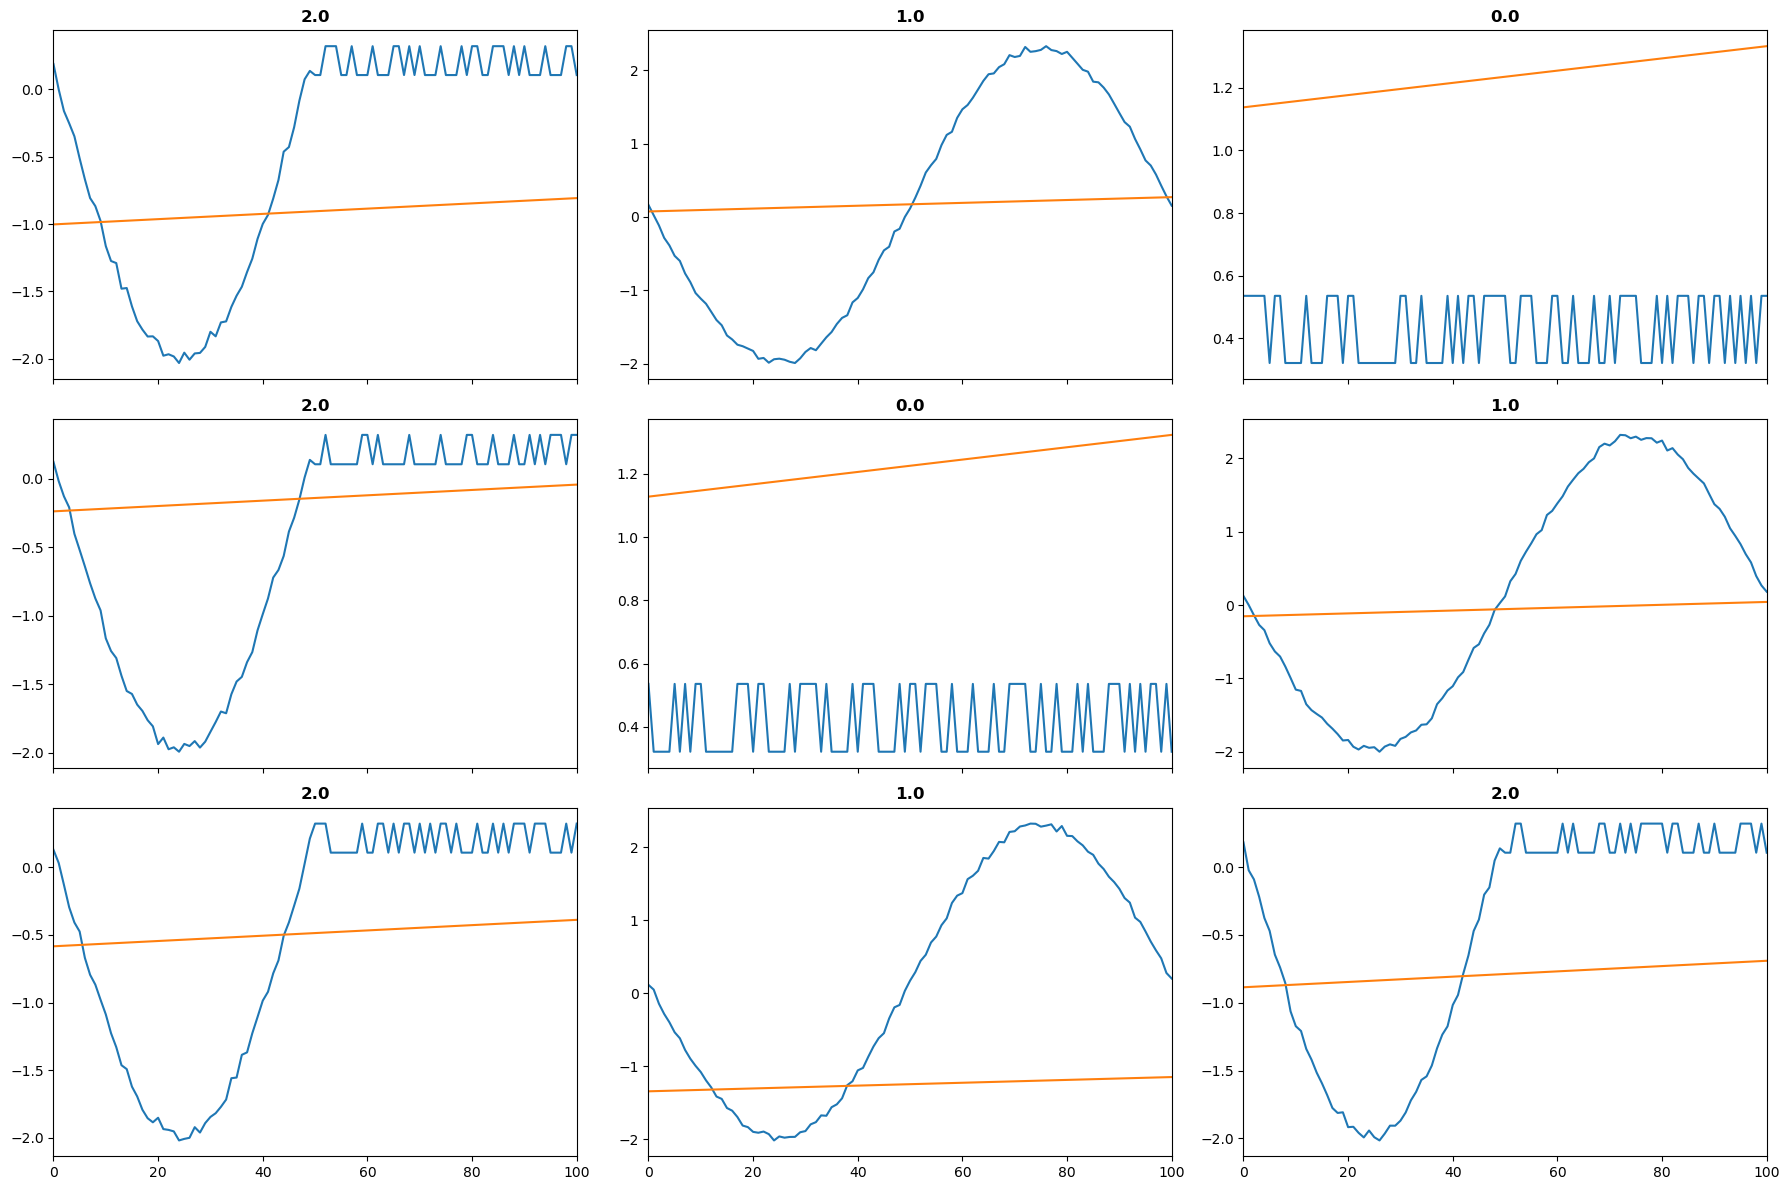

In [7]:
valid_dl = dls.valid
dls.show_batch()

In [8]:
xb, yb = dls.one_batch()

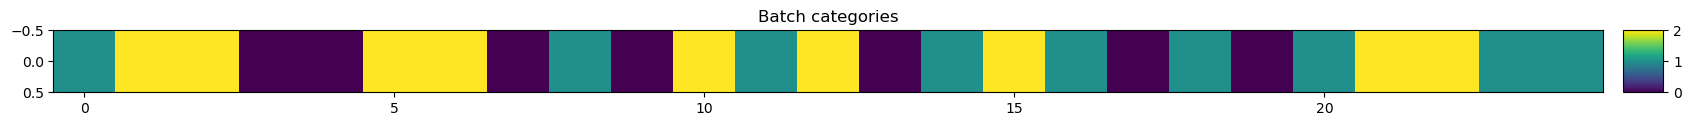

In [9]:
plot_batch(yb)

In [10]:

from tsai.all import Module, Permute, Unsqueeze, Squeeze, BatchNorm, noop, Concat, Conv2d
import torch.nn as nn

class LSTM_2dCNN(Module):
    def __init__(self, c_in, c_out, seq_len=None, hidden_size=100, rnn_layers=1, bias=True, cell_dropout=0, rnn_dropout=0.8, bidirectional=False, shuffle=True, 
                 fc_dropout=0., conv_layers=[128, 256, 128], kss=[7, 5, 3], se=0):
        
        if shuffle: assert seq_len is not None, 'need seq_len if shuffle=True'
            
        # RNN
        self.rnn = nn.LSTM(seq_len if shuffle else c_in, hidden_size, num_layers=rnn_layers, bias=bias, batch_first=True, 
                              dropout=cell_dropout, bidirectional=bidirectional)
        self.rnn_dropout = nn.Dropout(rnn_dropout) if rnn_dropout else noop
        self.shuffle = Permute(0,2,1) if not shuffle else noop # You would normally permute x. Authors did the opposite.
        
        # FCN
        assert len(conv_layers) == len(kss)
       

        #2dCNN
        self.conv2dblock = nn.Sequential(*[Unsqueeze(1), Conv2d(1, conv_layers[0], kernel_size=(1, seq_len), padding='same'), BatchNorm(conv_layers[0]), nn.ReLU()])
        self.conv2d1x1block = nn.Sequential(*[nn.Conv2d(conv_layers[0], 1, kernel_size=1), nn.ReLU(), Squeeze(1)])
        
        
        # Common
        self.concat = Concat()
        self.fc_dropout = nn.Dropout(fc_dropout) if fc_dropout else noop
        self.fc = nn.Linear(hidden_size * (1 + bidirectional) + (c_in)*seq_len, c_out)
        

    def forward(self, x):  
        # RNN
        rnn_input = self.shuffle(x) # permute --> (batch_size, seq_len, n_vars) when batch_first=True
        output, _ = self.rnn(rnn_input)
        last_out = output[:, -1] # output of last sequence step (many-to-one)
        last_out = self.rnn_dropout(last_out)
        
        #2dCNN
        x2 = self.conv2dblock(x)
        x2 = self.conv2d1x1block(x2)
        x2 = x2.reshape((x2.shape[0], x.shape[1]*x.shape[2]))
        #print(x2.shape)
       
        # Concat
        #print(x1.shape)
        x = self.concat([last_out, x2])
        x = self.fc_dropout(x)
        x = self.fc(x)
        
        return x
    
    

In [11]:
random_seed(0, use_cuda = True)
model = build_model(LSTM_2dCNN, dls=dls) 
print(model)
random_seed(0, use_cuda = True)
learn = Learner(dls, model,  metrics=accuracy)

LSTM_2dCNN(
  (rnn): LSTM(101, 100, batch_first=True)
  (rnn_dropout): Dropout(p=0.8, inplace=False)
  (conv2dblock): Sequential(
    (0): Unsqueeze(dim=1)
    (1): Conv2dSame(
      (conv2d_same): Conv2d(1, 128, kernel_size=(1, 101), stride=(1, 1))
    )
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2d1x1block): Sequential(
    (0): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Squeeze(dim=1)
  )
  (concat): Concat(dim=1)
  (fc): Linear(in_features=302, out_features=3, bias=True)
)


In [12]:
start = time.time()
lr = 0.001
random_seed(0, use_cuda = True)
learn.fit_flat_cos(5, lr)
elapsed = time.time() - start
vals = learn.recorder.values[-1]

epoch,train_loss,valid_loss,accuracy,time
0,0.061671,0.000545,1.000000,00:01
1,0.009840,0.000215,1.000000,00:01
2,0.001879,0.000103,1.000000,00:01
3,0.000404,0.000052,1.000000,00:01
4,0.000114,0.000038,1.000000,00:01


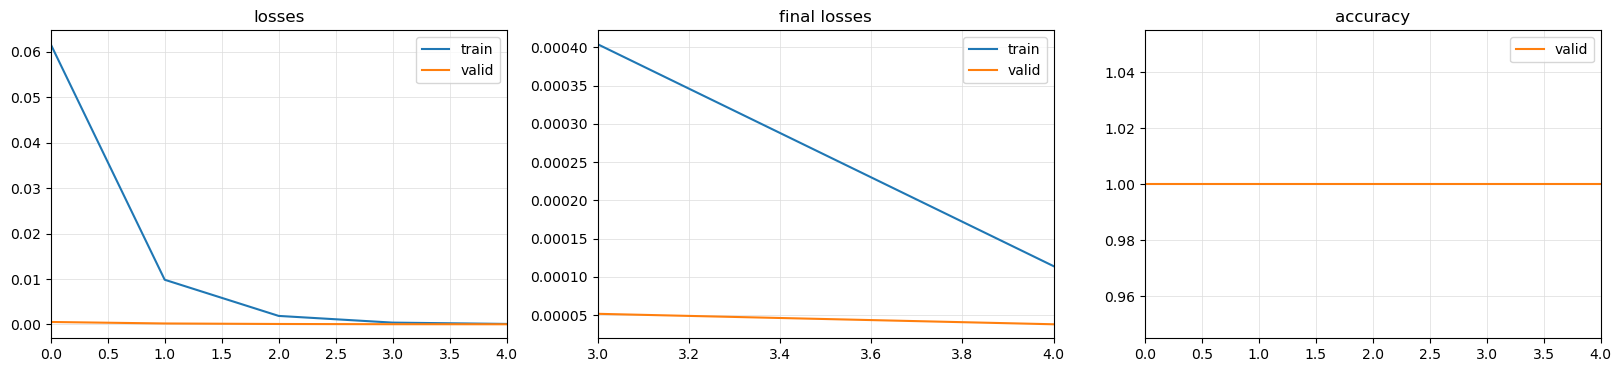

In [13]:
learn.recorder.plot_metrics()

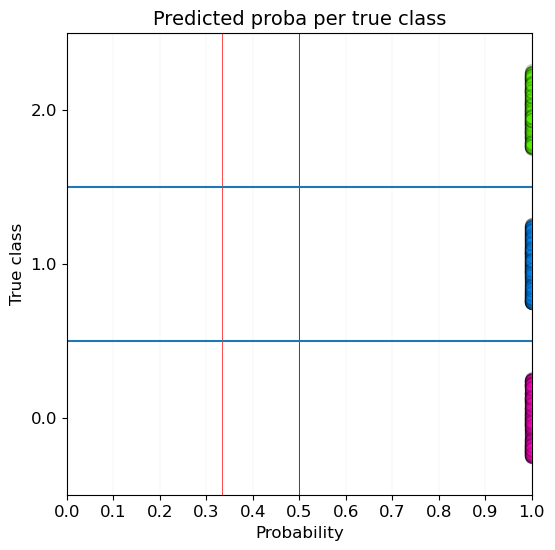

In [14]:
learn.show_probas()

### GradCAM

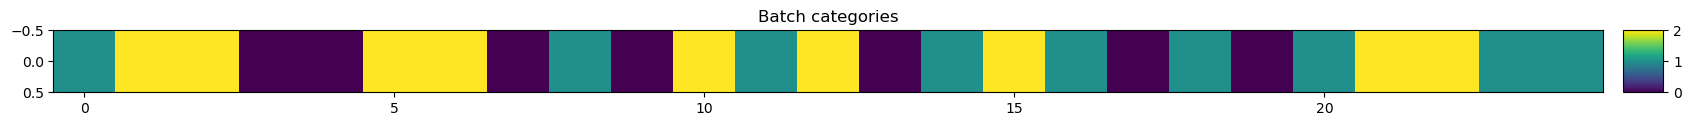

In [15]:
plot_batch(yb)

torch.Size([25, 128, 2, 101]) torch.Size([1, 128, 1, 1])
torch.Size([25, 2, 101])
TensorCategory([1, 2, 2, 0, 0, 2, 2, 0, 1, 0, 2, 1, 2, 0, 1, 2, 1, 0, 1, 0, 1,
                2, 2, 1, 1])
torch.Size([2, 101])


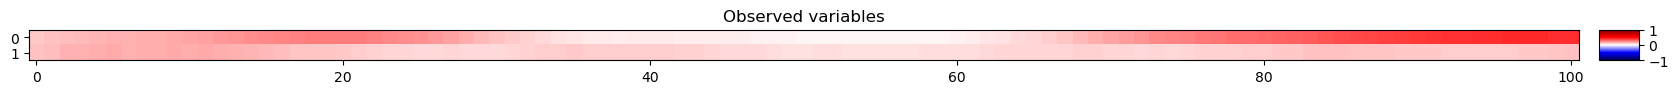

In [16]:
att_batch = Grad_2dCNN(model, xb) 
att_batch= (att_batch - att_batch.min()) / (att_batch.max() - att_batch.min())
print(yb)
plot_grad_overview(att_batch)

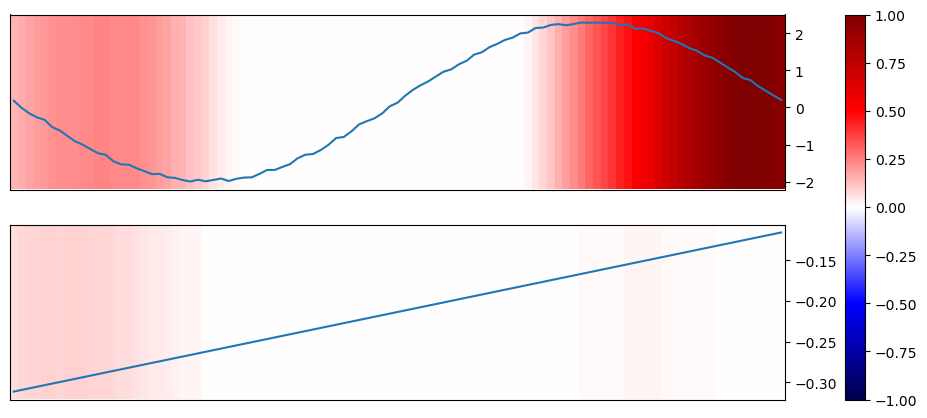

In [17]:
#for S0 (noise)
x = xb[0].detach().numpy()
att = att_batch[0]
plot_grad_detail(x, att)

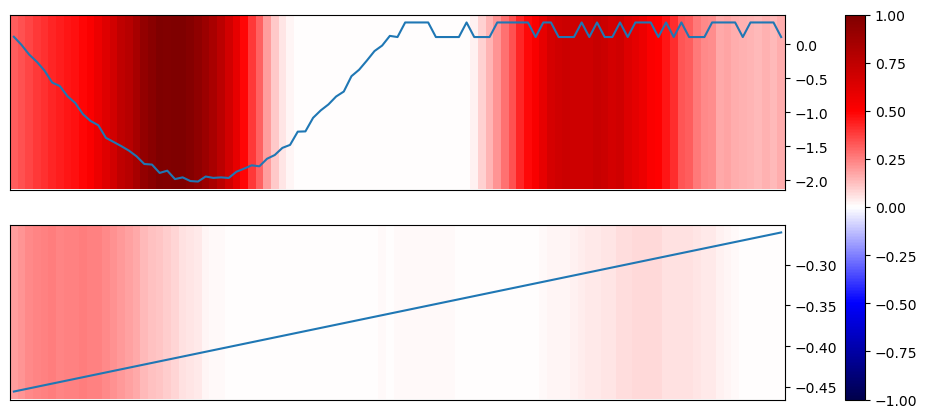

In [22]:
#for S1 (sine with noise)
x = xb[2].detach().numpy()
att = att_batch[2]
plot_grad_detail(x, att)

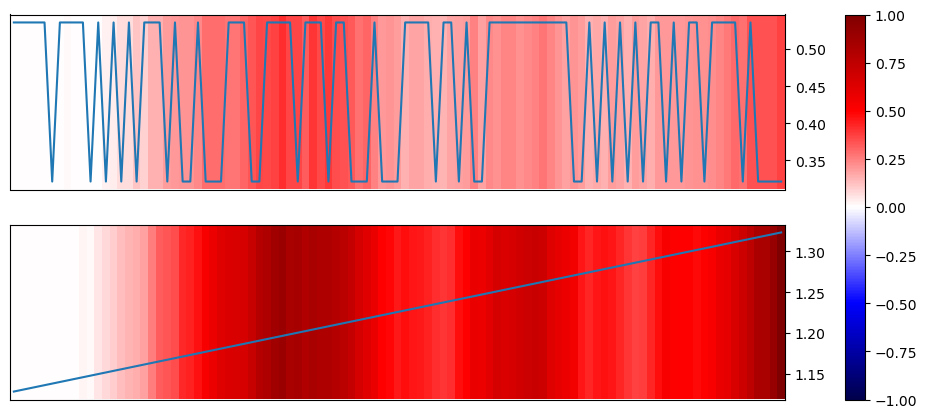

In [19]:
#for S2 (sine and line with noise)
x = xb[4].detach().numpy()
att = att_batch[4]
plot_grad_detail(x, att)

1
torch.Size([25, 2, 100])
torch.Size([25, 100, 2]) torch.Size([25, 1, 2])
torch.Size([25, 2])


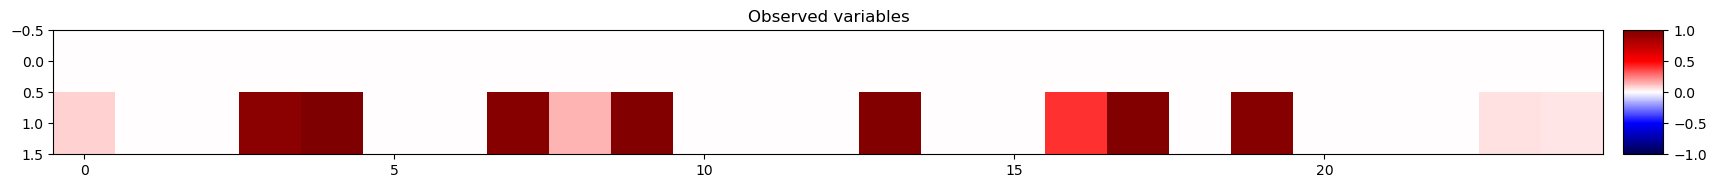

In [20]:
att_lstm = Grad_RNN(model, xb)
att_lstm= (att_lstm - att_lstm.min()) / (att_lstm.max() - att_lstm.min())
plot_grad_overview(att_lstm.T)

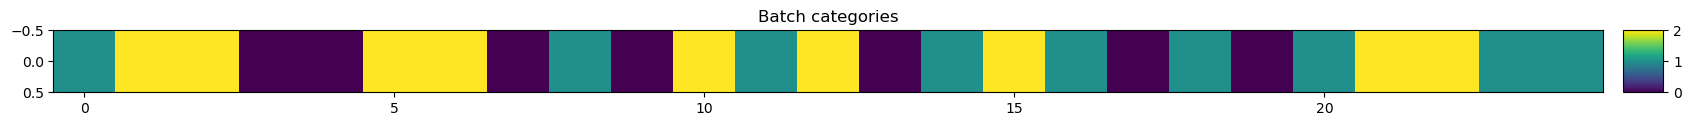

In [21]:
plot_batch(yb)